# Analysis Notebook
This Jupyter notebook contains important plots present in the paper with relevant descriptions. The first cell contains importing of relevant packages and code, make sure dependencies are fulfilled and compatible. 

In [1]:
from my_plotting import *
from my_functions import *
sns.set()
sns.set_style('ticks')

### Load important files
- pickled emulator, pca, and scaler
- training and validation set
- parameter set
- experimental data in relevant kinematical range
- parameter samples
- posterior samples (or just sample from the complete set)
- model values for posterior samples

In [2]:
# first decide if we are dealing with correlated setup and which model
correlated_ = True
model_ = "mv5/" # or "mv5" for the 5 parameter case

In [3]:
correlated_str = "corr/" if correlated_ else "uncorr/"
param_names = ["$Q_{s0}^{2}$ (GeV²)",
               "$\gamma$",
               "$e_c$",
               "$C^{2}$",
               "$\sigma_0/2$ (mb)"] if model_ == "mv5/" else ["$Q_{s0}^{2}$ (GeV²)",
               "$e_c$",
               "$C^{2}$",
               "$\sigma_0/2$ (mb)"]
n_params = 5 if model_ == "mv5/" else 4
# all files
folder = model_ + correlated_str
exp_file = "hera_allerrors.csv"
gpe_pkl = folder+"gpe.pkl"
pca_pkl = folder+"pca.pkl"
scaler_pkl = folder+"scaler.pkl"
train_file, theta_file = model_+"training/train.dat", model_+"training/theta.dat"
train_file_val, theta_file_val = model_+"validation/train.dat", model_+"validation/theta.dat"
theta_post_all_file = folder+"theta_all.dat"
train_file_post, theta_file_post = folder+"train.dat", folder+"theta.dat"
mean_model_file = folder+"mean.dat"
median_model_file = folder+"median.dat"
map_model_file = folder+"map.dat"

In [4]:
# load from files 
# Emulator and emulator predictions
emulators = loadfrompickle(gpe_pkl), loadfrompickle(pca_pkl), loadfrompickle(scaler_pkl)

# emulator training
train, theta = load_training_data(train_file, theta_file)
pred, err = return_predictions(emulators, theta, correlated=correlated_)

# emulator validation
train_val, theta_val = load_training_data(train_file_val, theta_file_val)
pred_val, err_val = return_predictions(emulators, theta_val, correlated=correlated_)

# emulator and bayesian posterior validation
train_post, theta_post = load_training_data(train_file_post, theta_file_post)
pred_post, err_post = return_predictions(emulators, theta_post, correlated=correlated_)

# Posterior samples
theta_post_all = np.vstack(np.loadtxt(theta_post_all_file))

# Experimental dataframe with columns:
exp_df, exp, exp_err, xbj = load_exp(exp_file, correlated = correlated_)

# mean, median and map values
l_bounds = [0.04, 0.9, 0.5, 2.0, 12.0] if model_ == "mv5/" else [0.04, 0.5, 2.0, 12.0]
u_bounds = [0.11, 1.1, 60.0, 10.0, 18.0] if model_ == "mv5/" else [0.11, 60.0, 10.0, 18.0]
median = np.median(theta_post_all, axis=0).reshape(1,-1)
mean = np.mean(theta_post_all, axis=0).reshape(1,-1)
MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err, correlated = correlated_), median.reshape(-1)).x
MAP = MAP.reshape(1,-1)
median_model = np.loadtxt(median_model_file)
mean_model = np.loadtxt(mean_model_file)
MAP_model = np.loadtxt(map_model_file)

/home/caaucasu/Documents/BayesianBK_results/my_functions.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df['uncor_tot'] = np.sqrt((exp_df['stat'])**2 + (exp_df['uncor'])**2) # total uncorrelated errors
/home/caaucasu/Documents/BayesianBK_results/my_functions.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df['cor_wo_proc'] = np.sqrt((exp_df['ignore'])**2 - (exp_df['uncor_tot'])**2) # total correlated uncertainties without procedural
/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/scipy/optimize

### Training Description
The training set is generated by sampling the parameter space with a latin hypercube design. The parameter space is defined by the following parameters: $Q_{s0}^2$, $\gamma$, $e_c$, $C^{2}$, $\sigma_0/2$. The final prior bounds used in the study is a result of multiple iterations of the Bayesian sampling and each time making, what was initially, a very generous parameter space even smaller for better emulator predictions. In a latin hypercube, the parameter vectors for the model to be calculated on and the emulator to be trained on are sampled evenly across the space such that there is no redundancy in each individual parameter.

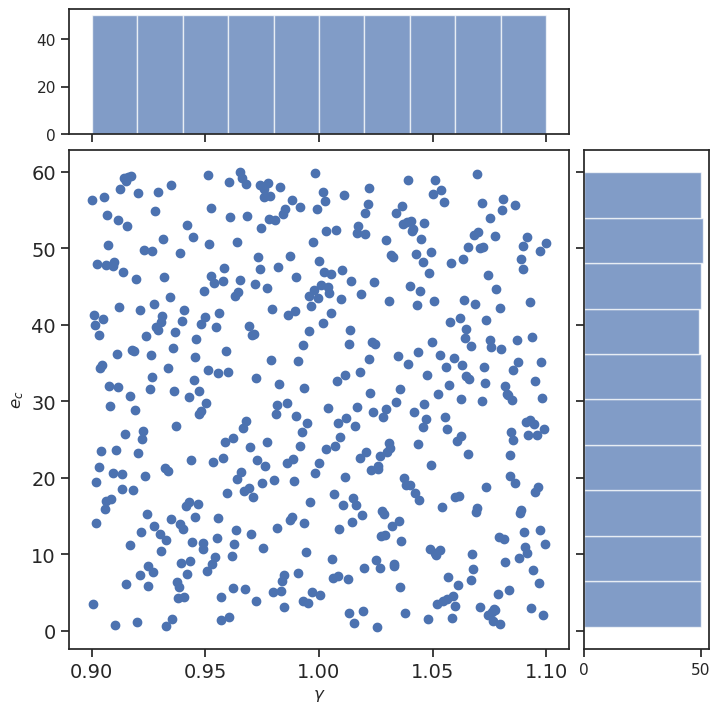

In [5]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
scatter_hist(1, 2, ax, ax_histx, ax_histy, theta, param_names)

### Emulator Validation
The following shows comparison of emulator prediction to HERA data and model calculation to a validation set of 100 parameter vectors to validate the emulator before feeding it into the bayesian sampler.

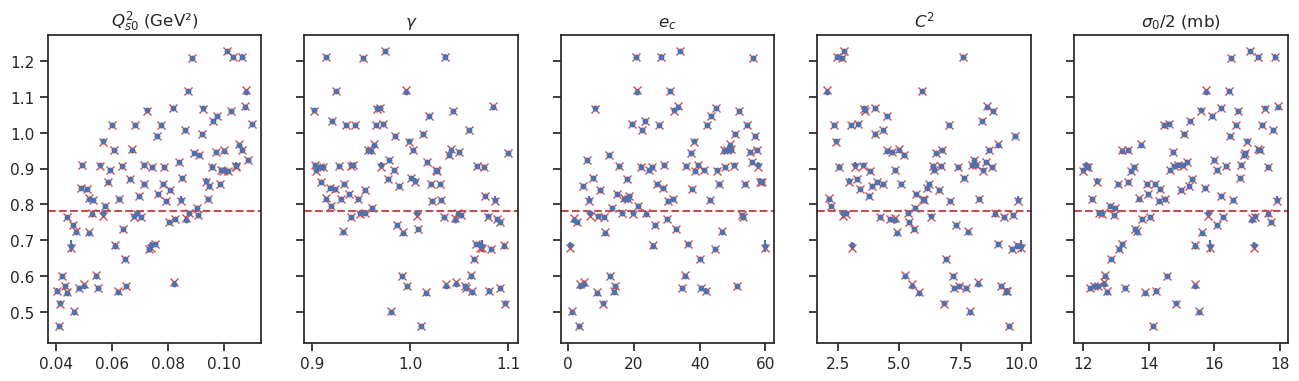

In [6]:
kp = 0
sd_val = np.sqrt(np.diagonal(err_val, axis1 = 1, axis2 = 2)) if correlated_ else err_val
fig, ax = plot_validation_perkp(0, pred_val, sd_val, train_val, exp, n_params, theta_val, param_names)

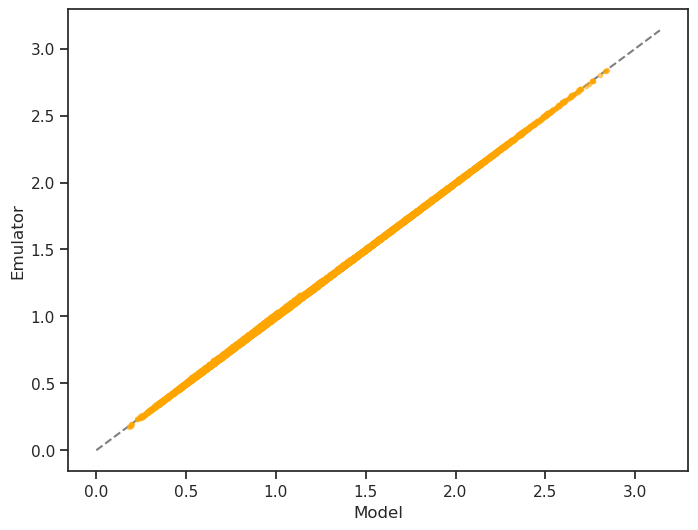

In [7]:
fig, ax = plot_diagonal(pred_val, train_val)

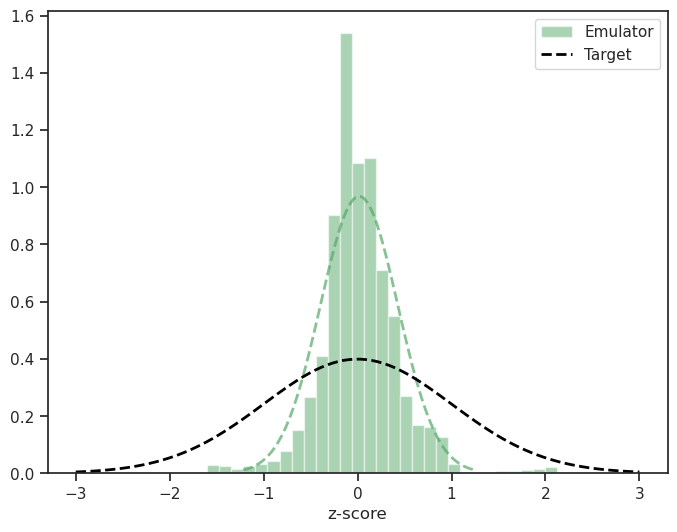

In [8]:
fig, ax = plot_zscore(pred_val, train_val, sd_val)

### Corner plot
Running the MCMC results to a posterior distribution describing the areas of high posterior probability. Diagonal plots of the triangle diagram are 1D projections of the posterior distribution for each parameter. The off-diagonal plots are 2D projections of the posterior distribution for each pair of parameters that show the correlation between the pair. The broken lines shows the parameter values at the posterior median, or the 50th percentile. Right after the corner plots, median and MAP values are printed for each parameter.

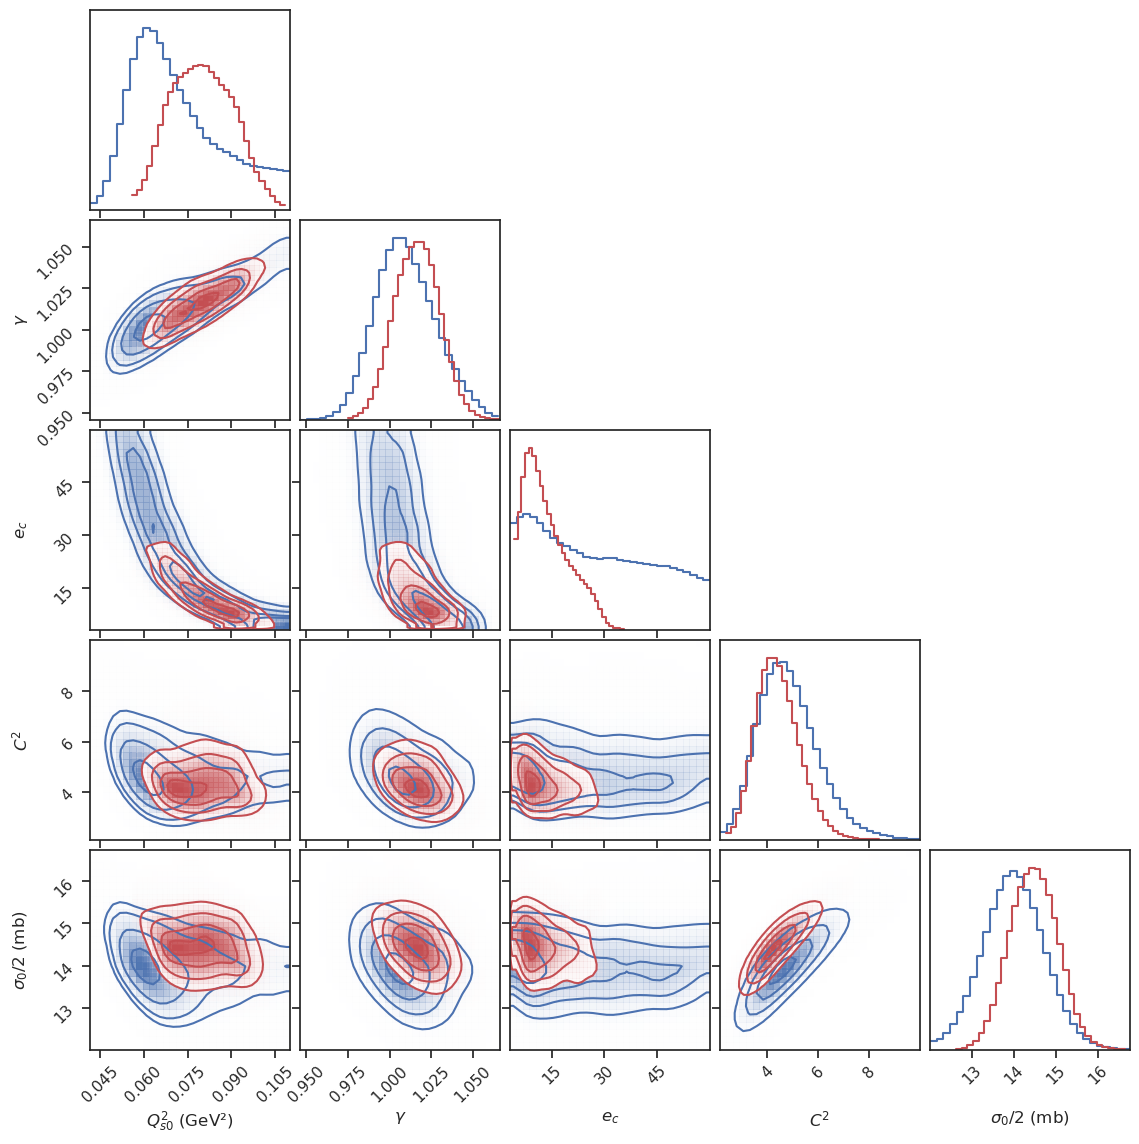

In [9]:
theta_tocompare = np.vstack(np.loadtxt("../BayesianBK/run_corr/mv5/plainLHS/mv5_500d_uncorr_05to60_100w_mapinit_allsamples.txt", unpack = True)).T
fig2, corner = plot_1corner(theta_post_all, param_names)
plot_corner_tocompare(theta_tocompare, fig2, corner)

/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/corner/core.py:768: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  return ax.set_xlim(new_xlim)


(<Figure size 1800x1800 with 21 Axes>,
 array([[<AxesSubplot: xlabel='$Q_{s0}^{2}$ [GeV²]'>,
         <AxesSubplot: xlabel='$e_c$'>, <AxesSubplot: xlabel='$C^{2}$'>,
         <AxesSubplot: xlabel='$\\sigma_0/2$ [mb]', ylabel='$Q_{s0}^{2}$ [GeV²]'>,
         <AxesSubplot: xlabel='$\\gamma$'>],
        [<AxesSubplot: ylabel='$e_c$'>, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: ylabel='$e_c$'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='$C^{2}$'>, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: ylabel='$C^{2}$'>,
         <AxesSubplot: >],
        [<AxesSubplot: ylabel='$\\sigma_0/2$ [mb]'>, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: xlabel='$Q_{s0}^{2}$ [GeV²]', ylabel='$\\gamma$'>,
         <AxesSubplot: xlabel='$e_c$'>, <AxesSubplot: xlabel='$C^{2}$'>,
         <AxesSubplot: xlabel='$\\sigma_0/2$ [mb]'>,
         <AxesSubplot: xlabel='$\\gamma$'>]], dtype=object))

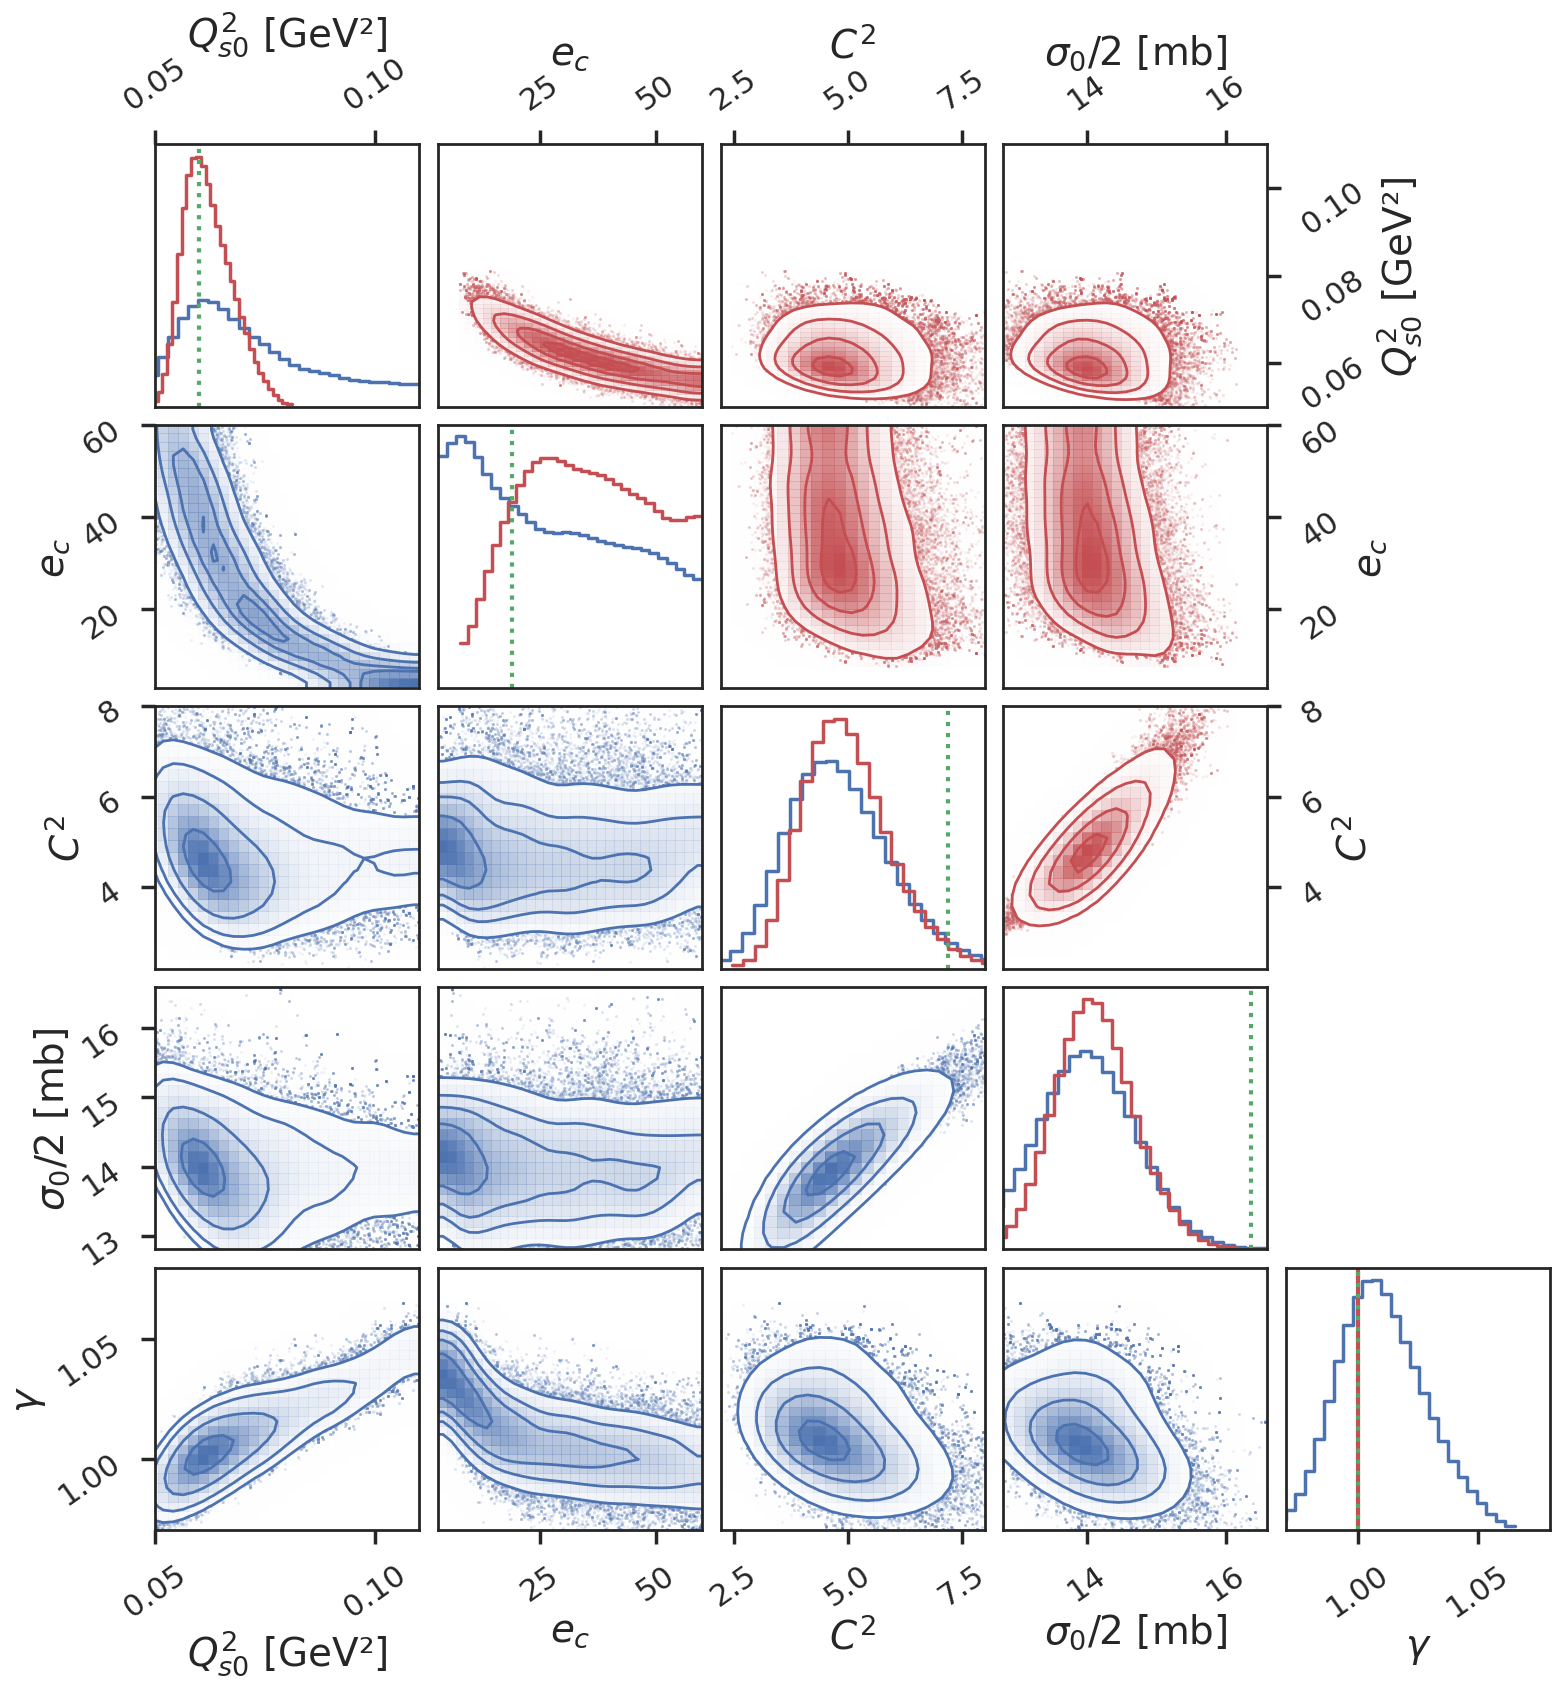

In [10]:
posterior_samples_mve= np.vstack(np.loadtxt("../BayesianBK/run_corr/mve/plainLHS/mve_500d_corr_05to60_100w_mapinit_allsamples.txt", unpack=True)).T
posterior_samples_mv5 = theta_post_all
posterior_samples_mv5 = np.insert(posterior_samples_mv5, 5, posterior_samples_mv5[:, 1], axis = 1)
posterior_samples_mv5 = np.delete(posterior_samples_mv5, 1, axis = 1)
posterior_samples_mve_gamma = 1.0*np.ones(len(posterior_samples_mve))
posterior_samples_mve = np.insert(posterior_samples_mve, 4, posterior_samples_mve_gamma, axis = 1)
posterior_samples_mve[0:200, 4] = 1.0
plot_corner(posterior_samples_mve, posterior_samples_mv5)

In [11]:
print("Mean", mean)
print("Median", median)
print("MAP", MAP)

Mean [[ 0.07153118  1.01006586 27.76604684  4.85220307 13.99738888]]
Median [[ 0.06763053  1.00859823 25.96687447  4.72630337 13.98930106]]
MAP [[ 0.07768079  1.01386768 14.73337902  4.46093019 13.86910557]]


### Posterior Validation
Next we visualize different results from sampling from the posterior and then comparing to HERA data the model calculation at the MAP/ Median values.

In [12]:
median_emulator, median_emulator_err = return_predictions(emulators, median, correlated=correlated_)
MAP_emulator, MAP_emulator_err = return_predictions(emulators, MAP, correlated=correlated_)

(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: title={'center': '5-parameter fit'}, xlabel='$x_{bj}$', ylabel='$\\sigma_r$ (mb)'>)

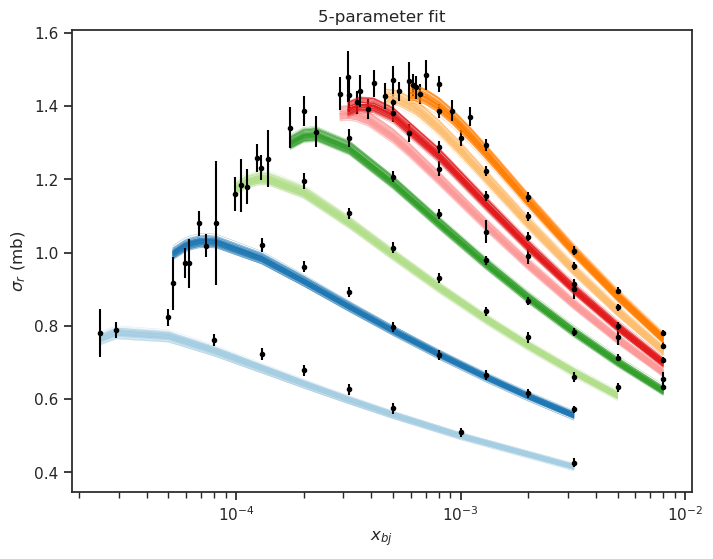

In [13]:
plot_model_vs_exp([2., 4.5, 8.5, 15.0, 22.0,  27.,  35.,  45.], 318.0, train_post, exp_df, exp_err, title_ = "{}-parameter fit".format(n_params), correlated = correlated_)
# 8.5, 15.0, 22.0,  27.,  35.,  45.

(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: title={'center': '5-parameter fit'}, xlabel='$x_{bj}$', ylabel='$\\sigma_r$'>)

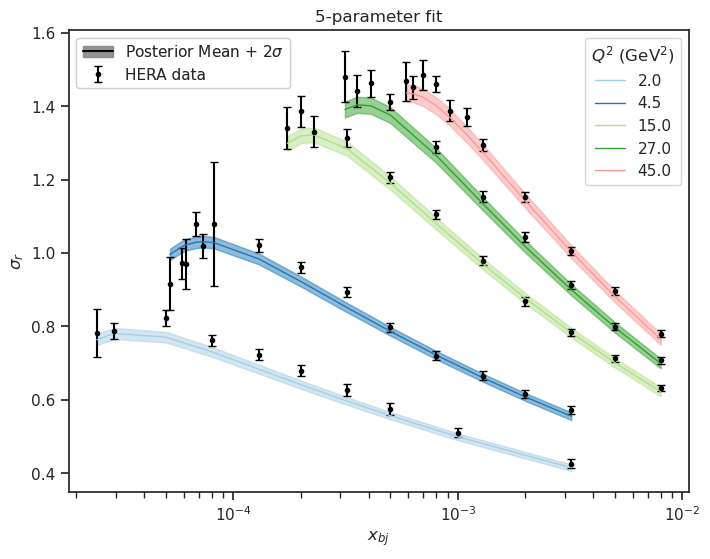

In [14]:
plot_posterior_mean_and_ub([2., 4.5, 15.0, 27., 45.], 318.0, train_post, exp_df, exp_err, title_ = "{}-parameter fit".format(n_params), correlated = correlated_)

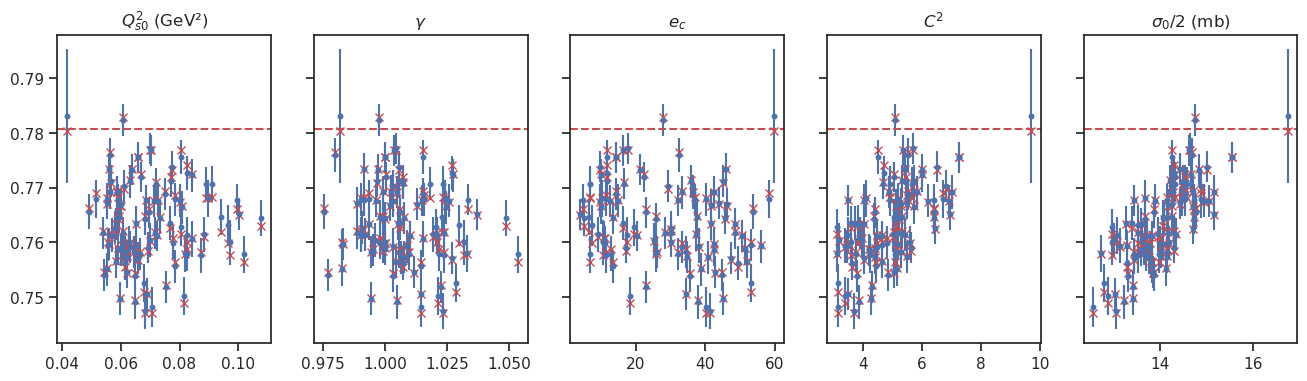

In [15]:
sd_post = np.sqrt(np.diagonal(err_post, axis1 = 1, axis2 = 2)) if correlated_ else err_post
fig, ax = plot_validation_perkp(0, pred_post, sd_post, train_post, exp, n_params, theta_post, param_names)

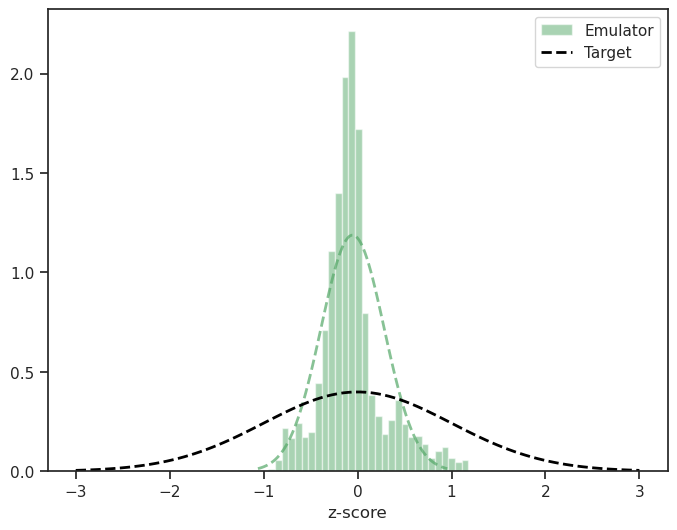

In [16]:
fig, ax = plot_zscore(pred_post, train_post, sd_post)

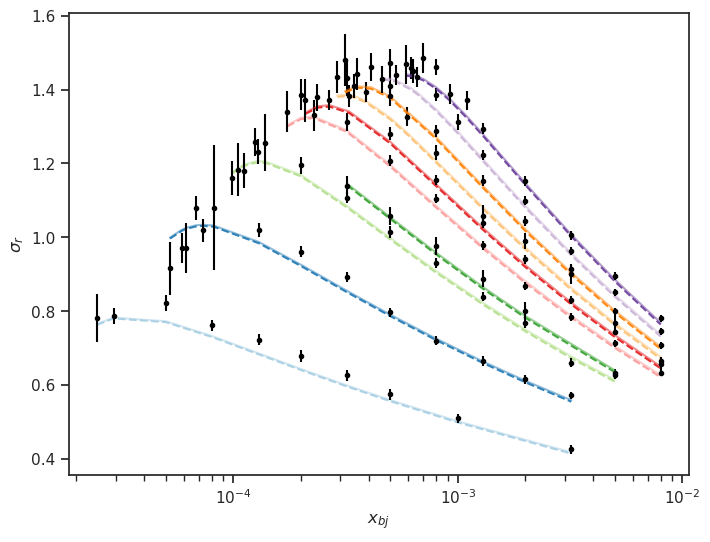

In [17]:
plot_exp_vs_map_vs_median([2., 4.5, 8.5, 10., 15., 18.,  22.,  27.,  35.,  45.], 318.0, MAP_model.reshape(1,403), exp_df, exp_err, median_model.reshape(1,403), correlated = correlated_)

(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: xlabel='Model', ylabel='Emulator'>)

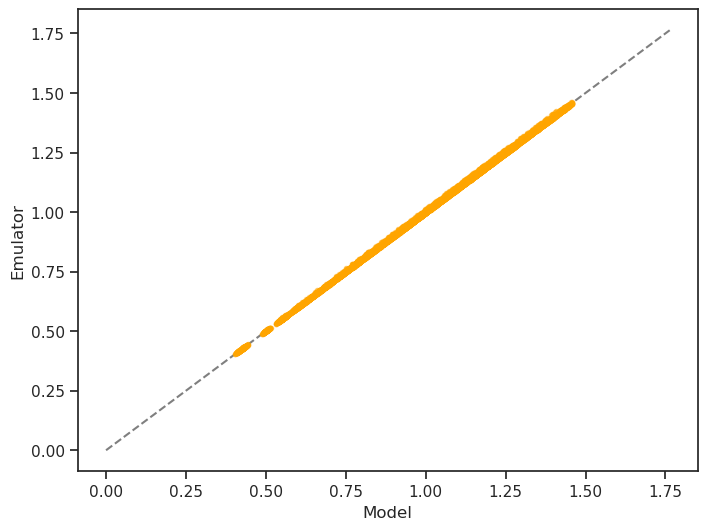

In [18]:
plot_diagonal(pred_post, train_post)

1.609096965319711

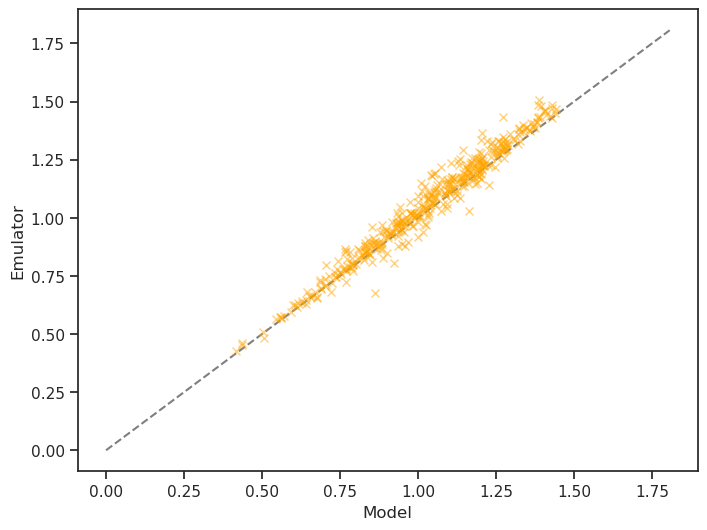

In [19]:
plot_diagonal_1(exp, median_model.reshape(403))
my_chi2(exp, median_model.reshape(403), np.sqrt(exp_err.diagonal()) if correlated_ else exp_err)

For the following predictions, we take 1000 samples from the posterior distribution and statistically rigorously calculate the median and standard deviation by calculating the quantity for 1000 of the samples and take the mean and sd for each x-value.

In [20]:
n = 1000
inds = np.random.randint(len(theta_post_all), size = n)
theta_post_1000 = np.array([theta_post_all[i] for i in inds])
# unravel the parameter vectors
e_cs = theta_post_1000[:, 2] if model_ == "mv5/" else theta_post_1000[:, 1]
Qs02s = theta_post_1000[:, 0]
sigma02s = theta_post_1000[:, -1]
gammas = theta_post_1000[:, 1] if model_ == "mv5/" else np.ones(n)

## Initial Dipole Amplitude Shape

In the following cells, we show the initial and evolved dipole amplitude that is constrained by the Bayesian analysis. The initial dipole amplitude is of the form:

$$ N(\mathbf{x}_{ij}, x=x_0) = 1-\exp \left[  - \frac{\left(\mathbf{x}_{ij}^2Q_{s,0}^2\right)^\gamma}{4} \right.
            \times \left. \ln \left( \frac{1}{|\mathbf{x}_{ij}| \Lambda_\text{QCD}}
             +  e_c\cdot  e   \right)   \right]. $$

We can see clearly here the model parameters that express the dipole amplitude. This is input to the BK evolution equation to evolve the dipole amplitude to higher energie and smaller $x$. The running strong coupling in the transverse plane is also input and is given by:

$$ \alpha_s(\mathbf{r}^2) = \frac{12\pi}{33-2n_f \ln\left( \frac{4C^2}{\mathbf{r}^2 \Lambda_{\mathrm{QCD}}^2} \right)}. $$

In [21]:
model_to_comp = "mv5" if model_ == "mve/" else "mve"
paramsamples_tocomp = np.vstack(np.loadtxt("../BayesianBK/run_corr/{0}/plainLHS/{0}_500d_corr_05to60_100w_mapinit_allsamples.txt".format(model_to_comp), unpack=True)).T
theta_tocomp_1000 = np.array([paramsamples_tocomp[i] for i in inds])
e_cs_comp = theta_tocomp_1000[:, 2] if model_to_comp == "mv5" else theta_tocomp_1000[:, 1]
Qs02s_comp = theta_tocomp_1000[:, 0]
sigma02s_comp = theta_tocomp_1000[:, -1]
gammas_comp = theta_tocomp_1000[:, 1] if model_to_comp == "mv5" else np.ones(n)

In [22]:
rs = np.logspace(-2,1,50)
iBK = get_iBK_upsd_downsd(Qs02s, gammas, e_cs, rs)
iBK_usd = iBK[0]+ 2*iBK[1]
iBK_dsd = iBK[0]- 2*iBK[2]

iBK_comp = get_iBK_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, rs)
iBK_comp_usd = iBK_comp[0]+ 2*iBK_comp[1]
iBK_comp_dsd = iBK_comp[0]- 2*iBK_comp[2]

# plot evolved bk now
where_bk_mve = "../BayesianBK/run_corr/mve/plainLHS/100d_post/corr/bks"
eBK_mve = get_eBK_upsd_downsd(where_bk_mve, rs)
eBK_mve_usd = eBK_mve[0]+ 2*eBK_mve[1]
eBK_mve_dsd = eBK_mve[0]- 2*eBK_mve[2]

where_bk_mv5 = "../BayesianBK/run_corr/mv5/plainLHS/100d_post/corr/bks"
eBK_mv5 = get_eBK_upsd_downsd(where_bk_mv5, rs)
eBK_mv5_usd = eBK_mv5[0]+ 2*eBK_mv5[1]
eBK_mv5_dsd = eBK_mv5[0]- 2*eBK_mv5[2]

Text(0.5, 0.14, '$x = 10^{-2}$')

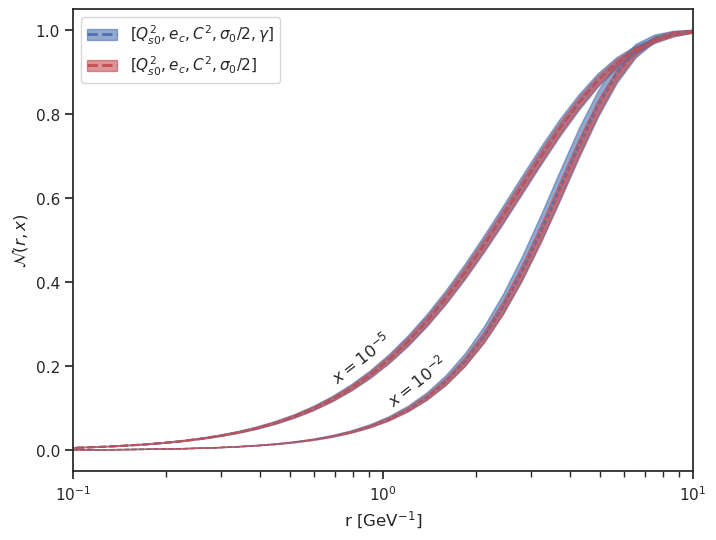

In [44]:
# plot initial bk
fig, ax = plot_pred_mve_vs_mv5(iBK_comp, iBK, rs, r"$\mathcal{N}(r,x)$", "r [GeV$^{-1}$]", legend_loc = "upper left", linewidth_=1.0)

ax.plot(rs, eBK_mv5[0], '--', color = "b")
ax.fill_between(rs, eBK_mv5_usd, eBK_mv5_dsd, color = "b", alpha = 0.6)
ax.plot(rs, eBK_mve[0], '--', color = "r")
ax.fill_between(rs, eBK_mve_usd, eBK_mve_dsd, color = "r", alpha = 0.6)
ax.set_xscale("log")
ax.set_xlim(.1, 10)
ax.text(0.41, 0.19, r'$x = 10^{-5}$', transform=ax.transAxes, rotation = 38)
ax.text(0.5, 0.14, r'$x = 10^{-2}$', transform=ax.transAxes, rotation = 38)

## Application: 2DFT Dipole Amplitude

Given the optimal parameter vector distribution, we can optimize the initial condition for the BK equation where the agreement with HERA is max. Using these "initial conditions", we can provide CGC LO prediction for observables describing pp and pA collisions at the LHC (and in the future, EIC) like particle production. One example is the 2D fourier transform of the dipole proton amplitude which can be directly calculated from the initial condition $N(r)$:


$$ \tilde{S}(k_{T}) = \int d²r e^{ik \cdot r} [1 - N(r)] = 2 \pi \int dr r J_0(k*r) (1 - N(r))$$

In [24]:
k = np.logspace(-1,1,50)
sp = get_2DFT_upsd_downsd(Qs02s, gammas, e_cs, k)
sp_usd = sp[0]+ 2*sp[1]
sp_dsd = sp[0]- 2*sp[2]

sp_comp = get_2DFT_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, k)
sp_comp_usd = sp_comp[0]+ 2*sp_comp[1]
sp_comp_dsd = sp_comp[0]- 2*sp_comp[2]

(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: xlabel='$k$ [GeV]', ylabel='$\\tilde{S}_{p}(k) [GeV^{-2}]$'>)

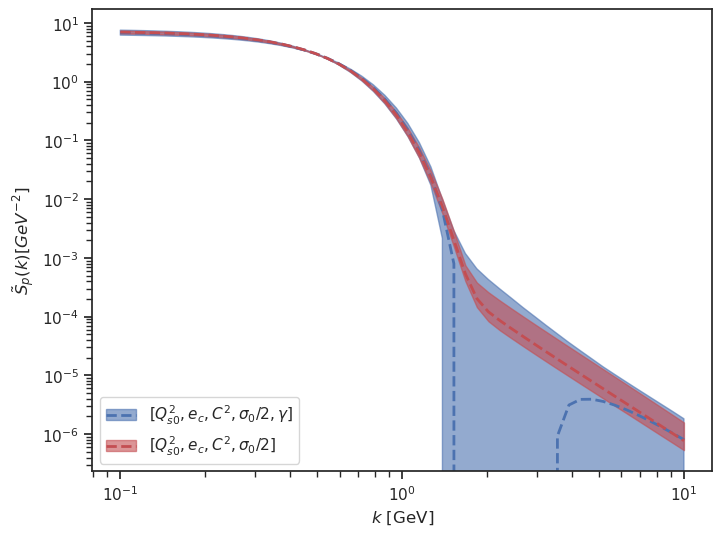

In [46]:
plot_pred_mve_vs_mv5(sp_comp, sp, k, r'$\tilde{S}_{p}(k) [GeV^{-2}]$', "$k$ [GeV]", legend_loc = "lower left", xlogscale= True, ylogscale = True)

(-2.0, 4.0)

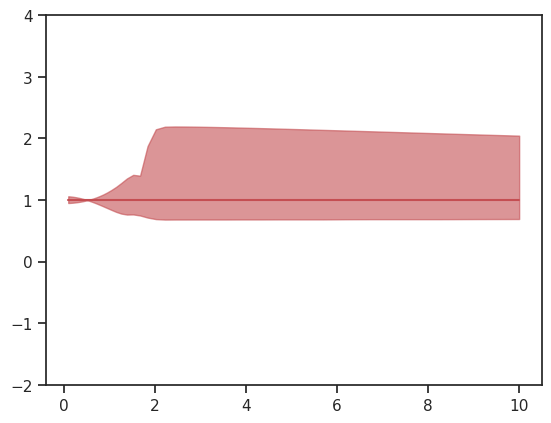

In [26]:
sp_norm = sp_comp[0]/sp_comp[0]
sp_norm_usd = sp_comp_usd/sp_comp[0]
sp_norm_dsd = sp_comp_dsd/sp_comp[0]
plt.plot(k, sp_norm, color = "r")
plt.fill_between(k, sp_norm_usd, sp_norm_dsd, alpha = 0.6, color = "r")
plt.ylim(-2.0, 4.0)